### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, ode
from scipy import interpolate
from types import SimpleNamespace
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator
import matplotlib as mpl
from os.path import expanduser

from lib.utils_generate_n import n_r, n_i
from lib.utils_generate_W import get_grid, gauss_dist
from lib.utils_general import diff_same_length

In [7]:
# plt.rcParams['figure.figsize'] = [15,10]

In [2]:
half_width = 5
nmbr_points = 10000
grid, stepsize = get_grid(half_width, nmbr_points)

In [4]:
home = expanduser("~")
path_here = home + '/MEGAsync/Projektarbeit/Code/'
#path_here = home + '/MEGA/MEGAsync/Projektarbeit/Code/'
path_plots = 'plots/'

### Plot Configurations

In [5]:
# ----------------------------m-----------------
# PLOT CONFIGURATIONS
# ---------------------------------------------

# Change to the directory which contains the current script
# dirFile = os.path.dirname(os.path.join(path_here,
#                                        'evaluate_model.py'))
# Load style file
plt.style.use('file://' + path_here + 'PaperDoubleFig.mplstyle')
# Make some style choices for plotting
colourWheel = ['#329932',
               '#ff6961',
               'b',
               '#6a3d9a',
               '#fb9a99',
               '#e31a1c',
               '#fdbf6f',
               '#ff7f00',
               '#cab2d6',
               '#6a3d9a',
               '#ffff99',
               '#b15928',
               '#67001f',
               '#b2182b',
               '#d6604d',
               '#f4a582',
               '#fddbc7',
               '#f7f7f7',
               '#d1e5f0',
               '#92c5de',
               '#4393c3',
               '#2166ac',
               '#053061']
dashesStyles = [[3, 1],
                [1000, 1],
                [2, 1, 10, 1],
                [4, 1, 1, 1, 1, 1]]

### Plot Gauss-W and n

Tatsächlich beeinflusst der k-Wert die Form von nr soweit, dass das Netz mglw den k-Wert aus der Form von nr auswendig lernen könnte, wenn als W immer nur die selben Gauss-Glocken verwendet werden.

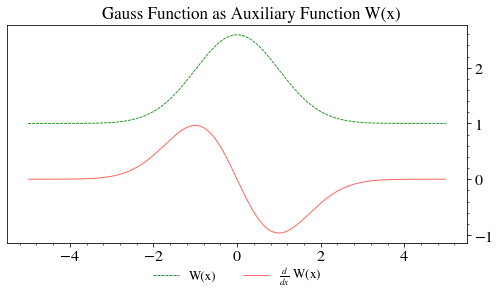

In [8]:
W = 10*gauss_dist(0,1,grid) + 1
dW = diff_same_length(W, stepsize)

plt.close('all')
fig, ax = plt.subplots()
alphaVal = 1#0.6
linethick = 1

plt.plot(grid,
         W, 
         color=colourWheel[0 % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[0 % len(dashesStyles)],
         lw=linethick,
         label = r'W(x)',
         alpha=alphaVal)
plt.plot(grid,
         dW, 
         color=colourWheel[1 % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[1 % len(dashesStyles)],
         lw=linethick,
         label = r'$\frac{d}{dx}$ W(x)',
         alpha=alphaVal)

ax.set_xlabel('')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.major.formatter._useMathText = True
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_label_coords(0.53, 1.01)
ax.yaxis.tick_right()
nameOfPlot = 'Gauss Function as Auxiliary Function W(x)'
plt.ylabel(nameOfPlot, rotation=0)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
legend = ax.legend(frameon=False,
                   loc='upper center',
                   bbox_to_anchor=(0.5, -0.05),
                   ncol=4)

fig.savefig(path_plots + 'GaussW.pdf', bbox_inches="tight", dpi=300)
plt.show()

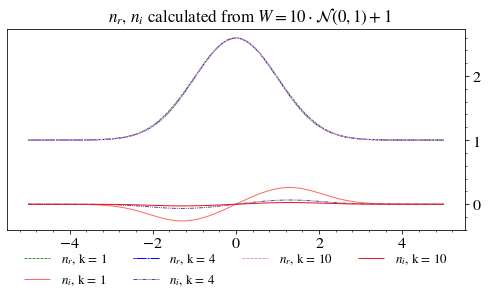

In [48]:
plt.close('all')
fig, ax = plt.subplots()
alphaVal = 1#0.6
linethick = 1

for i,k in enumerate([1, 4, 10]):
    nr = n_r(W, dW, grid, k)
    ni = n_i(dW, nr, grid, k)
    
    plt.plot(grid,
         nr, 
         color=colourWheel[(2*i) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(2*i) % len(dashesStyles)],
         lw=linethick,
         label = r'$n_r$, k = ' + str(k),
         alpha=alphaVal)

    plt.plot(grid,
         ni, 
         color=colourWheel[(2*i + 1) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(2*i + 1) % len(dashesStyles)],
         lw=linethick,
         label = r'$n_i$, k = ' + str(k),
         alpha=alphaVal)    
    
ax.set_xlabel('')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.major.formatter._useMathText = True
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_label_coords(0.53, 1.01)
ax.yaxis.tick_right()
nameOfPlot = '$n_r$, $n_i$ calculated from $W = 10 \cdot \mathcal{N}(0,1) + 1$'
plt.ylabel(nameOfPlot, rotation=0)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
legend = ax.legend(frameon=False,
                   loc='upper center',
                   bbox_to_anchor=(0.5, -0.05),
                   ncol=4)

fig.savefig(path_plots + 'Gauss_nrni.pdf', bbox_inches="tight", dpi=300)
plt.show()

Deshalb neues Datenset mit unterschiedlichen sigmas bei den Gauss-Gocken und mehreren k's zu selbigem W, dann sollte das erkennen des k-Wertes aus nr nicht mehr möglich sein.

### Andres Bootstrapping Approach

In [40]:
def solve_ni(nr, ni0, ni1, k, stepsize):
    
    ni = np.zeros(len(nr))
    W = np.zeros(len(nr))
    dW = np.zeros(len(nr))
    
    ni[0] = ni0
    ni[1] = ni1
    W[0] = np.sqrt(nr[0]**2 - ni[0]**2)
    W[1] = np.sqrt(nr[1]**2 - ni[1]**2)
    dW[1] = (W[1] - W[0])/stepsize
    #print('dW[1]', dW[1])
    
    for i in range(2,len(nr)):
        ni[i] = - dW[i-1]/(2*k*nr[i])
        #print('ni[i]', ni[i])
        W[i] = np.sqrt(nr[i]**2 - ni[i]**2)
        dW[i] = (W[i] - W[i-1])/stepsize
        
    return W, ni

In [41]:
W_approx, ni_approx = solve_ni(nr, ni[0], ni[1], 1, stepsize)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


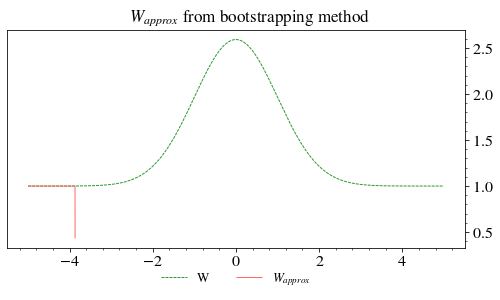

In [47]:
frame = 10000

plt.close('all')
fig, ax = plt.subplots()
alphaVal = 1#0.6
linethick = 1

plt.plot(grid[:frame],
         W[:frame], 
         color=colourWheel[(0) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(0) % len(dashesStyles)],
         lw=linethick,
         label='W',
         alpha=alphaVal)
plt.plot(grid[:frame],
         W_approx[:frame], 
         color=colourWheel[(1) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(1) % len(dashesStyles)],
         lw=linethick,
         label='$W_{approx}$',
         alpha=alphaVal)

ax.set_xlabel('')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.major.formatter._useMathText = True
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_label_coords(0.53, 1.01)
ax.yaxis.tick_right()
nameOfPlot = '$W_{approx}$ from bootstrapping method'
plt.ylabel(nameOfPlot, rotation=0)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
legend = ax.legend(frameon=False,
                   loc='upper center',
                   bbox_to_anchor=(0.5, -0.05),
                   ncol=4)

fig.savefig(path_plots + 'bootstrap_all.pdf', bbox_inches="tight", dpi=300)
plt.show()

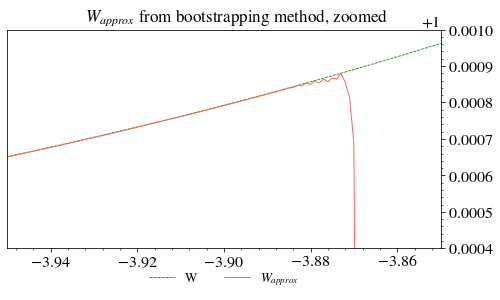

In [67]:
frame = 1200

plt.close('all')
fig, ax = plt.subplots()
alphaVal = 1#0.6
linethick = 1

plt.plot(grid[:frame],
         W[:frame], 
         color=colourWheel[(0) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(0) % len(dashesStyles)],
         lw=linethick,
         label='W',
         alpha=alphaVal)
plt.plot(grid[:frame],
         W_approx[:frame], 
         color=colourWheel[(1) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(1) % len(dashesStyles)],
         lw=linethick,
         label='$W_{approx}$',
         alpha=alphaVal)

plt.ylim(1.0004, 1.001)
plt.xlim(-3.95, -3.85)

ax.set_xlabel('')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.major.formatter._useMathText = True
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_label_coords(0.53, 1.01)
ax.yaxis.tick_right()
nameOfPlot = '$W_{approx}$ from bootstrapping method, zoomed'
plt.ylabel(nameOfPlot, rotation=0)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
legend = ax.legend(frameon=False,
                   loc='upper center',
                   bbox_to_anchor=(0.5, -0.05),
                   ncol=4)

fig.savefig(path_plots + 'bootstrap_small.pdf', bbox_inches="tight", dpi=300)
plt.show()

### Check if ODE is correct

In [81]:
def dni(ni,nr,dnr,k):
    if ni == 0:
        if dnr == 0:
            dni1, dni2 = 0, 0
        else:
            print('dnr should be = 0 here')
            dni1, dni2 = 2.17, 2.17 # some value that raises error
    else:
        dni1 = (nr*dnr + 2*k*nr*ni*np.sqrt(nr**2 - ni**2)) / ni
        dni2 = (nr*dnr - 2*k*nr*ni*np.sqrt(nr**2 - ni**2)) / ni
    return dni1, dni2

In [82]:
idx=9000
print('nr[{}]: {}'.format(idx,nr[idx]))
print('dnr[{}]: {}'.format(idx,nr_diff[idx]))
print('ni[{}]: {}'.format(idx,ni[idx]))
print('dni[{}]: {}'.format(idx,ni_diff[idx]))

ni_diff_fps, ni_diff_fms = dni(ni[idx], nr[idx], nr_diff[idx], k)
print('+ solution: ', ni_diff_fps)
print('- solution: ', ni_diff_fms)

# obviously the positive solution is what we need
# this formula works incredibly well, as long as ni is not 0

nr[9000]: 1.0005344724213678
dnr[9000]: -0.0021358564363797654
ni[9000]: 0.0010652415335555916
dni[9000]: -0.003986036978048941
+ solution:  -0.0039785877529011195
- solution:  -4.008253240287228


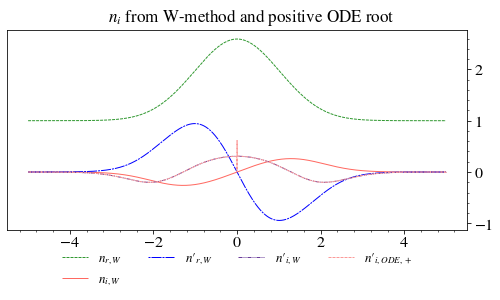

In [99]:
plt.close('all')
fig, ax = plt.subplots()
alphaVal = 1#0.6
linethick = 1

ni_diff_fp = np.zeros(len(grid))
ni_diff_fm = np.zeros(len(grid))

for i in range(len(grid)):
    ni_diff_fp[i] = dni(ni[i], nr[i], nr_diff[i], k)[0]
    ni_diff_fm[i] = dni(ni[i], nr[i], nr_diff[i], k)[1]
    
plt.plot(grid,
         nr, 
         color=colourWheel[(0) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(0) % len(dashesStyles)],
         lw=linethick,
         label='$n_{r,W}$',
         alpha=alphaVal)

plt.plot(grid,
         ni, 
         color=colourWheel[(1) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(1) % len(dashesStyles)],
         lw=linethick,
         label='$n_{i,W}$',
         alpha=alphaVal)

plt.plot(grid,
         nr_diff, 
         color=colourWheel[(2) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(2) % len(dashesStyles)],
         lw=linethick,
         label='$n\prime_{r,W}$',
         alpha=alphaVal)

plt.plot(grid,
         ni_diff, 
         color=colourWheel[(3) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(3) % len(dashesStyles)],
         lw=linethick,
         label='$n\prime_{i,W}$',
         alpha=alphaVal)

plt.plot(grid, 
         ni_diff_fp, 
         color=colourWheel[(4) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(4) % len(dashesStyles)],
         lw=linethick,
         label='$n\prime_{i,ODE,+}$',
         alpha=alphaVal)

# plt.plot(grid, 
#          ni_diff_fm, 
#          color=colourWheel[(5) % len(colourWheel)],
#          linestyle='-',
#          dashes=dashesStyles[(5) % len(dashesStyles)],
#          lw=linethick, 
#          label='$n\prime_{i,ODE,-}$',
#          alpha=alphaVal)

# plt.plot(grid, 
#          np.zeros(len(grid)),
#          color=colourWheel[(6) % len(colourWheel)],
#          linestyle='-',
#          dashes=dashesStyles[(6) % len(dashesStyles)],
#          lw=linethick,
#          alpha=alphaVal)

ax.set_xlabel('')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.major.formatter._useMathText = True
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_label_coords(0.53, 1.01)
ax.yaxis.tick_right()
nameOfPlot = '$n_i$ from W-method and positive ODE root'
plt.ylabel(nameOfPlot, rotation=0)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
legend = ax.legend(frameon=False,
                   loc='upper center',
                   bbox_to_anchor=(0.5, -0.05),
                   ncol=4)

fig.savefig(path_plots + 'ni_ODEp_W.pdf', bbox_inches="tight", dpi=300)
plt.show()

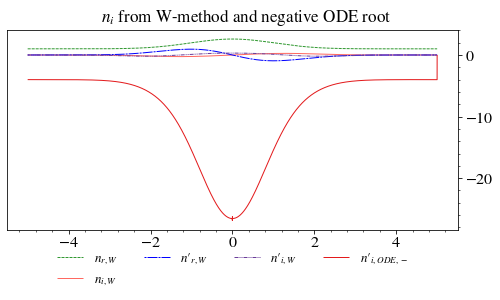

In [100]:
plt.close('all')
fig, ax = plt.subplots()
alphaVal = 1#0.6
linethick = 1

ni_diff_fp = np.zeros(len(grid))
ni_diff_fm = np.zeros(len(grid))

for i in range(len(grid)):
    ni_diff_fp[i] = dni(ni[i], nr[i], nr_diff[i], k)[0]
    ni_diff_fm[i] = dni(ni[i], nr[i], nr_diff[i], k)[1]
    
plt.plot(grid,
         nr, 
         color=colourWheel[(0) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(0) % len(dashesStyles)],
         lw=linethick,
         label='$n_{r,W}$',
         alpha=alphaVal)

plt.plot(grid,
         ni, 
         color=colourWheel[(1) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(1) % len(dashesStyles)],
         lw=linethick,
         label='$n_{i,W}$',
         alpha=alphaVal)

plt.plot(grid,
         nr_diff, 
         color=colourWheel[(2) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(2) % len(dashesStyles)],
         lw=linethick,
         label='$n\prime_{r,W}$',
         alpha=alphaVal)

plt.plot(grid,
         ni_diff, 
         color=colourWheel[(3) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(3) % len(dashesStyles)],
         lw=linethick,
         label='$n\prime_{i,W}$',
         alpha=alphaVal)

# plt.plot(grid, 
#          ni_diff_fp, 
#          color=colourWheel[(4) % len(colourWheel)],
#          linestyle='-',
#          dashes=dashesStyles[(4) % len(dashesStyles)],
#          lw=linethick,
#          label='$n\prime_{i,ODE,+}$',
#          alpha=alphaVal)

plt.plot(grid, 
         ni_diff_fm, 
         color=colourWheel[(5) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(5) % len(dashesStyles)],
         lw=linethick, 
         label='$n\prime_{i,ODE,-}$',
         alpha=alphaVal)

# plt.plot(grid, 
#          np.zeros(len(grid)),
#          color=colourWheel[(6) % len(colourWheel)],
#          linestyle='-',
#          dashes=dashesStyles[(6) % len(dashesStyles)],
#          lw=linethick,
#          alpha=alphaVal)

ax.set_xlabel('')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.major.formatter._useMathText = True
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_label_coords(0.53, 1.01)
ax.yaxis.tick_right()
nameOfPlot = '$n_i$ from W-method and negative ODE root'
plt.ylabel(nameOfPlot, rotation=0)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
legend = ax.legend(frameon=False,
                   loc='upper center',
                   bbox_to_anchor=(0.5, -0.05),
                   ncol=4)

fig.savefig(path_plots + 'ni_ODEm_W.pdf', bbox_inches="tight", dpi=300)
plt.show()

### Integrate with Euler per Hand


In [101]:
ni_interp = interpolate.interp1d(grid, ni)

args = SimpleNamespace(u = interpolate.interp1d(grid, nr),
                       du = interpolate.interp1d(grid, nr_diff),
                       k = k)

def f(x, y, args): #ni, nr, dnr, k
    return ( args.u(x)*args.du(x)/y + 2*k*args.u(x)*np.sqrt(np.abs(args.u(x))**2 - np.abs(y)**2))

In [102]:
sol = np.zeros(len(grid))
sol[0] = ni[0]

for i in range(len(grid)-1):
    sol[i+1] = sol[i] + stepsize*f(grid[i], sol[i], args)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


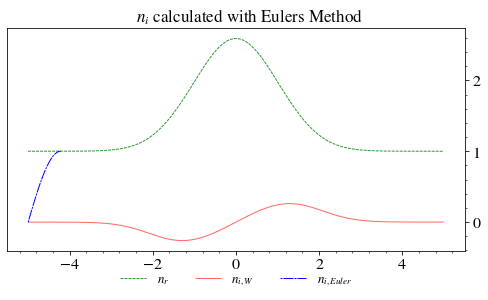

In [112]:
plt.close('all')
fig, ax = plt.subplots()
alphaVal = 1#0.6
linethick = 1

plt.plot(grid[:len(sol)],
         nr[:len(sol)], 
         color=colourWheel[(0) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(0) % len(dashesStyles)],
         lw=linethick,
         label='$n_r$',
         alpha=alphaVal)

plt.plot(grid[:len(sol)],
         ni, 
         color=colourWheel[(1) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(1) % len(dashesStyles)],
         lw=linethick,
         label='$n_{i,W}$',
         alpha=alphaVal)

plt.plot(grid[:len(sol)],
         sol, 
         color=colourWheel[(2) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(2) % len(dashesStyles)],
         lw=linethick,
         label='$n_{i,Euler}$',
         alpha=alphaVal)

ax.set_xlabel('')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.major.formatter._useMathText = True
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_label_coords(0.53, 1.01)
ax.yaxis.tick_right()
nameOfPlot = '$n_i$ calculated with Eulers Method'
plt.ylabel(nameOfPlot, rotation=0)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
legend = ax.legend(frameon=False,
                   loc='upper center',
                   bbox_to_anchor=(0.5, -0.05),
                   ncol=4)

fig.savefig(path_plots + 'Euler.pdf', bbox_inches="tight", dpi=300)
plt.show()

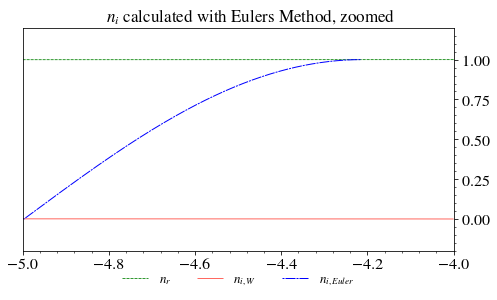

In [111]:
plt.close('all')
fig, ax = plt.subplots()
alphaVal = 1#0.6
linethick = 1

plt.plot(grid[:len(sol)],
         nr[:len(sol)], 
         color=colourWheel[(0) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(0) % len(dashesStyles)],
         lw=linethick,
         label='$n_r$',
         alpha=alphaVal)

plt.plot(grid[:len(sol)],
         ni, 
         color=colourWheel[(1) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(1) % len(dashesStyles)],
         lw=linethick,
         label='$n_{i,W}$',
         alpha=alphaVal)

plt.plot(grid[:len(sol)],
         sol, 
         color=colourWheel[(2) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(2) % len(dashesStyles)],
         lw=linethick,
         label='$n_{i,Euler}$',
         alpha=alphaVal)

plt.ylim(-0.2, 1.2)
plt.xlim(-5, -4)

ax.set_xlabel('')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.major.formatter._useMathText = True
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_label_coords(0.53, 1.01)
ax.yaxis.tick_right()
nameOfPlot = '$n_i$ calculated with Eulers Method, zoomed'
plt.ylabel(nameOfPlot, rotation=0)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
legend = ax.legend(frameon=False,
                   loc='upper center',
                   bbox_to_anchor=(0.5, -0.05),
                   ncol=4)

fig.savefig(path_plots + 'Euler_zoom.pdf', bbox_inches="tight", dpi=300)
plt.show()

### Integrate ODE with SciPy

In [181]:
ni_interp = interpolate.interp1d(grid, ni)

args = SimpleNamespace(u = interpolate.interp1d(grid, nr),
                       du = interpolate.interp1d(grid, nr_diff),
                       k = k)

def f(x, y, args): #ni, nr, dnr, k
    return args.u(x)*args.du(x)/y + 2*k*args.u(x)*np.sqrt(np.abs(args.u(x))**2 - np.abs(y)**2)

func = lambda y,x : f(x,y, args)

# funcneg = lambda y,x : fneg(x,y, args)

ni0_half1 =  ni[0]- 0.0001 # error in the IV
last_idx = 10000#10000

In [182]:
ni_sci_half1 = odeint(func , ni0_half1, grid[:last_idx])

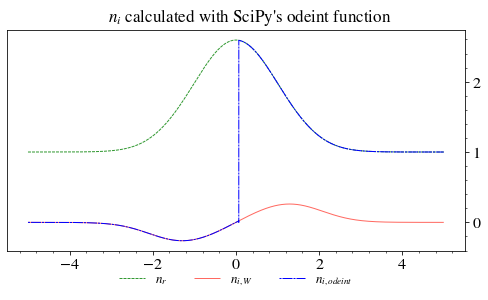

In [184]:
plt.close('all')
fig, ax = plt.subplots()
alphaVal = 1#0.6
linethick = 1

plt.plot(grid[:last_idx],
         nr[:last_idx], 
         color=colourWheel[(0) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(0) % len(dashesStyles)],
         lw=linethick,
         label='$n_r$',
         alpha=alphaVal)
plt.plot(grid[:last_idx],
         ni[:last_idx], 
         color=colourWheel[(1) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(1) % len(dashesStyles)],
         lw=linethick,
         label='$n_{i,W}$',
         alpha=alphaVal)
plt.plot(grid[:last_idx],
         ni_sci_half1[:last_idx], 
         color=colourWheel[(2) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(2) % len(dashesStyles)],
         lw=linethick,
         label='$n_{i,odeint}$',
         alpha=alphaVal)

ax.set_xlabel('')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.major.formatter._useMathText = True
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_label_coords(0.53, 1.01)
ax.yaxis.tick_right()
nameOfPlot = '$n_i$ calculated with SciPy\'s odeint function' 
plt.ylabel(nameOfPlot, rotation=0)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
legend = ax.legend(frameon=False,
                   loc='upper center',
                   bbox_to_anchor=(0.5, -0.05),
                   ncol=4)

fig.savefig(path_plots + 'odeint.pdf', bbox_inches="tight", dpi=300)
plt.show()

In [189]:
first_idx = 5500
interval = 1000

ni0_half2 = ni[first_idx] #- 0.00001
ni_sci_half2 = odeint(func , ni0_half2, grid[first_idx:first_idx+interval])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


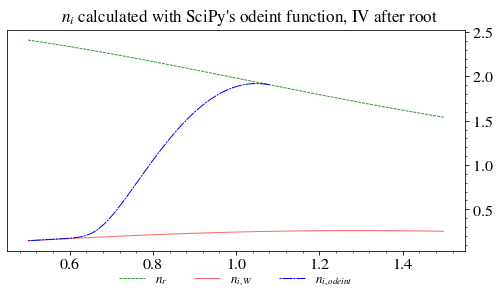

In [192]:
# there is obviously a problem with positive numbers
plt.close('all')
fig, ax = plt.subplots()
alphaVal = 1#0.6
linethick = 1

plt.plot(grid[first_idx:first_idx+interval],
         nr[first_idx:first_idx+interval], 
         color=colourWheel[(0) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(0) % len(dashesStyles)],
         lw=linethick,
         label='$n_r$',
         alpha=alphaVal)

plt.plot(grid[first_idx:first_idx+interval],
         ni[first_idx:first_idx+interval], 
         color=colourWheel[(1) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(1) % len(dashesStyles)],
         lw=linethick,
         label='$n_{i,W}$',
         alpha=alphaVal)

plt.plot(grid[first_idx:first_idx+interval],
         ni_sci_half2, 
         color=colourWheel[(2) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(2) % len(dashesStyles)],
         lw=linethick,
         label='$n_{i,odeint}$',
         alpha=alphaVal)

ax.set_xlabel('')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.major.formatter._useMathText = True
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_label_coords(0.53, 1.01)
ax.yaxis.tick_right()
nameOfPlot = '$n_i$ calculated with SciPy\'s odeint function, IV after root'
plt.ylabel(nameOfPlot, rotation=0)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
legend = ax.legend(frameon=False,
                   loc='upper center',
                   bbox_to_anchor=(0.5, -0.05),
                   ncol=4)

fig.savefig(path_plots + 'odeint_positive.pdf', bbox_inches="tight", dpi=300)
plt.show()

### Numerov Solution Method

In [196]:
half_width = 5
nmbr_points = 10000
grid, stepsize = get_grid(half_width, nmbr_points)

W = 10*gauss_dist(0,1,grid) + 1
dW = diff_same_length(W, stepsize)

nr = n_r(W, dW, grid, k = 1)
ni = n_i(dW, nr, grid, k = 1)

In [197]:
def numerov_step(y0,y1,h,U2,U1,U0,V2,V1,V0):
    # returns y2, all inputs complex
    s = h**2/12
    F0 = U0+V0*y0
    F1 = U1+V1*y1
    F2 = U2+V2*y2
    return (2*y1 - y0 + s*(U2 + 10*F1 + F0))/(1 - s*V2)

In [198]:
def init_val_in(x, dx, k, A):
    """
    Calculates a complex wave in empty space and returns the first two values. 
    Needed as start values for the numerov algorithm. 
    """
    
    psi = np.zeros(2, dtype=complex)
    
    for i in range(len(psi)):
        psi[i] = A * np.cos(x[i]*k) + 1j * A * np.sin(x[i]*k) 
    
    return psi[0].real, psi[1].real, psi[0].imag, psi[1].imag


def numerov(x, dx, n, psi_r0, psi_r1, psi_i0, psi_i1, k):
    """
    Implementation of the numerov algorithm for the helmholtz equation. 
    Needs two initial values and returns the complex wave as a numpy array.
    """
    
    psi = np.zeros(len(x), dtype=complex)
    psi[0] = complex(psi_r0, psi_i0) #Startwerte
    psi[1] = complex(psi_r1, psi_i1)
    
    s = dx**2/12 * k**2
    
    for i in range(len(x)-2):
                
        psi[i+2] = ( 2*( 1-5*s*n[i+1]**2 )*psi[i+1] - ( 1+s*n[i+1]**2 )*psi[i] )/(1 +  s*n[i+2]**2)
        
    return psi

In [199]:
iv = init_val_in(x = grid,
                 dx = stepsize,
                 k = 1,
                 A = 1)

psi= numerov(x = grid,  # this is fine
             dx = stepsize,
             n = nr + 1j*ni,
             psi_r0 = iv[0], 
             psi_r1 = iv[1], 
             psi_i0 = iv[2], 
             psi_i1 = iv[3], 
             k = 1)

idx = 0

print('true ni value: ', ni[idx])

def C(h,k,psi0,psi1,n1,n0):
    # all variables are complex
    s = h**2/12*k**2
    return np.abs(2*(1-5*s*n1**2)*psi1 - (1 + s*n0**2)*psi0)**2

print('psi[idx-2] : ',psi[idx-2])
print('psi[idx-1] : ',psi[idx-1])

Cidx = C(h = stepsize,
         k = 1,
         psi0 = psi[idx-2],
         psi1 = psi[idx-1],
         n1 = nr[idx-1] + 1j*ni[idx-1],
         n0 = nr[idx] + 1j*ni[idx])

print('C value: ',Cidx) # should be right

def gsi(nr,
        h, 
        k,
        Cidx): 
    # this is ni**2
    s = h**2 / 12 * k**2
    print('s: ',s)
    a = s**2
    b = 2*s**2*nr**2 - 2*s**2*nr**2 - 2*s
    c = 1 + 2*s*nr**2 + s**2*nr**4 - Cidx
    
    gsi1 = ( - b + np.sqrt(b**2 - 4*a*c))/(2*a) 
    gsi2 = ( - b - np.sqrt(b**2 - 4*a*c))/(2*a)
    print('disc: ', b**2 - 4*a*c)
    return gsi1, gsi2, a, b, c 

gsi1, gsi2, a, b, c = gsi(nr = nr[idx],
                          h = stepsize,
                          k = 1,
                          Cidx = Cidx)

print('a,b,c:',a,b,c)
print('gsi1, gsi2: ', gsi1, gsi2)
print('ni: ',np.sqrt(gsi1),np.sqrt(gsi2),-np.sqrt(gsi1),-np.sqrt(gsi2))

true ni value:  -1.4863435031072812e-05
psi[idx-2] :  (-0.9060616077501239+0.4235631625179732j)
psi[idx-1] :  (-0.9064848630148747+0.4226569198014582j)
C value:  1.0003541346194431
s:  8.333333333338899e-08
disc:  2.7787610220892462e-14
a,b,c: 6.944444444453721e-15 -1.6666666666677798e-07 -0.00035396795079245535
gsi1, gsi2:  24002123.619782012 -2123.6197980423512
ni:  4899.196221808432 nan -4899.196221808432 nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in sqrt


### Brute Force Optimization

In [225]:
W = 10*gauss_dist(0,1,grid) + 1
dW = diff_same_length(W, stepsize)
k = 1
nr = n_r(W, dW, grid, k)
nr_diff = diff_same_length(nr, stepsize)
ni = n_i(dW, nr, grid, k)

# plt.plot(grid,W,label='W')
# plt.plot(grid,dW,label='dW')
# plt.plot(grid,nr,label='nr')
# plt.plot(grid,ni,label='ni')
# plt.plot(grid,nr_diff,label='dnr')
# plt.legend()

In [204]:
def init_val_in(x, dx, k, A):
    """
    Calculates a complex wave in empty space and returns the first two values. 
    Needed as start values for the numerov algorithm. 
    """
    
    psi = np.zeros(2, dtype=complex)
    
    for i in range(len(psi)):
        psi[i] = A * np.cos(x[i]*k) + 1j * A * np.sin(x[i]*k) 
    
    return psi[0].real, psi[1].real, psi[0].imag, psi[1].imag


def numerov(x, dx, n, psi_r0, psi_r1, psi_i0, psi_i1, k):
    """
    Implementation of the numerov algorithm for the helmholtz equation. 
    Needs two initial values and returns the complex wave as a numpy array.
    """
    
    psi = np.zeros(len(x), dtype=complex)
    psi[0] = complex(psi_r0, psi_i0) #Startwerte
    psi[1] = complex(psi_r1, psi_i1)
    
    s = dx**2/12 * k**2
    
    for i in range(len(x)-2):
                
        psi[i+2] = ( 2*( 1-5*s*n[i+1]**2 )*psi[i+1] - ( 1+s*n[i+1]**2 )*psi[i] )/(1 +  s*n[i+2]**2)
        
    return psi

def numerov_step(dx, n0, n1, n2, psi0, psi1, k):

    s = dx**2/12 * k**2                
    psi2 = ( 2*( 1-5*s*n1**2 )*psi1 - ( 1+s*n1**2 )*psi0 )/(1 +  s*n2**2)
        
    return psi2


In [211]:
iv = init_val_in(grid, stepsize, 1, 1)
psi = numerov(grid, stepsize, nr + 1j*ni, iv[0], iv[1], iv[2], iv[3], k=1)

In [217]:
def func(val, *args):
    idx, ni0, ni1, psi0, psi1 = args
    n0 = complex(nr[idx-2], ni0)
    n1 = complex(nr[idx-1], ni1)
    n2 = complex(nr[idx], val)
    psi2 = numerov_step(dx = stepsize, 
                 n0 = n0,
                 n1 = n1,
                 n2 = n2,
                 psi0 = psi0, 
                 psi1 = psi1, 
                 k = 1)
    out = np.abs(np.abs(psi2)**2 - np.abs(psi[idx])**2)**2 # np.abs(psi[idx])**2
    return out

last_idx = 10000

# initial values
ni_calc = np.zeros(len(nr))
ni_calc[0] = ni[0] 
ni_calc[1] = ni[1]
psi_calc = np.zeros(len(nr), dtype = complex)
psi_calc[0] = complex(iv[0], iv[2])
psi_calc[1] = complex(iv[1], iv[3])

# calc first ni
ni_calc[2] = minimize(fun=func, 
         x0=0,
         args=(2, ni[0], ni[1], psi_calc[0], psi_calc[1]),
         method='Nelder-Mead',
         tol=1e-8).x

# loop for all values 
for idx in range(2,last_idx-1):
    # calculate next psi
    psi_calc[idx] = numerov_step(dx = stepsize, 
                 n0 = nr[idx-2] + 1j*ni[idx-2],
                 n1 = nr[idx-1] + 1j*ni[idx-1],
                 n2 = nr[idx] + 1j*ni[idx],
                 psi0 = psi_calc[idx-2], 
                 psi1 = psi_calc[idx-1], 
                 k = 1)
    
    # calculate next ni by optimization
    ni_calc[idx+1] = minimize(fun=func, 
             x0=0,
             args=(idx+1, ni[idx-1], ni[idx], psi_calc[idx-1], psi_calc[idx]),
             method='Nelder-Mead',
             tol=1e-8).x    
    
print(ni[:last_idx])
print(ni_calc[:last_idx])
print(psi_calc)

[-1.48634350e-05 -1.49349351e-05 -1.50067634e-05 ...  1.50067630e-05
  1.49349345e-05 -0.00000000e+00]
[-1.48634350e-05 -1.49349351e-05  0.00000000e+00 ...  0.00000000e+00
  3.12500000e-05  0.00000000e+00]
[ 0.28366219+0.95892427j  0.28270312+0.95920746j  0.28174377+0.95948968j
 ... -0.90563745+0.42446898j -0.90606161+0.42356316j
  0.        +0.j        ]


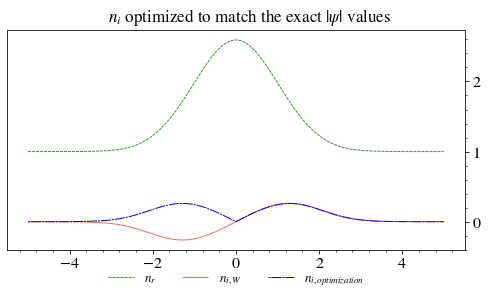

In [222]:
plt.close('all')
fig, ax = plt.subplots()
alphaVal = 1#0.6
linethick = 1

plt.plot(grid, 
         nr[:last_idx], 
         color=colourWheel[(0) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(0) % len(dashesStyles)],
         lw=linethick, 
         label = '$n_r$',
         alpha=alphaVal)

plt.plot(grid, 
         ni[:last_idx], 
         color=colourWheel[(1) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(1) % len(dashesStyles)],
         lw=linethick, 
         label = '$n_{i,W}$',
         alpha=alphaVal)

plt.plot(grid, 
         ni_calc[:last_idx], 
         color=colourWheel[(2) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(2) % len(dashesStyles)],
         lw=linethick, 
         label = '$n_{i,optimization}$',
         alpha=alphaVal)

ax.set_xlabel('')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.major.formatter._useMathText = True
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_label_coords(0.53, 1.01)
ax.yaxis.tick_right()
nameOfPlot = '$n_i$ optimized to match the exact $|\psi|$ values'
plt.ylabel(nameOfPlot, rotation=0)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
legend = ax.legend(frameon=False,
                   loc='upper center',
                   bbox_to_anchor=(0.5, -0.05),
                   ncol=4)

fig.savefig(path_plots + 'optimization_exact.pdf', bbox_inches="tight", dpi=300)
plt.show()

In [223]:
def func(val, *args):
    idx, ni0, ni1, psi0, psi1 = args
    n0 = complex(nr[idx-2], ni0)
    n1 = complex(nr[idx-1], ni1)
    n2 = complex(nr[idx], val)
    psi2 = numerov_step(dx = stepsize, 
                 n0 = n0,
                 n1 = n1,
                 n2 = n2,
                 psi0 = psi0, 
                 psi1 = psi1, 
                 k = 1)
    out = np.abs(np.abs(psi2)**2 - 1)**2 # np.abs(psi[idx])**2
    return out

last_idx = 10000

# initial values
ni_calc = np.zeros(len(nr))
ni_calc[0] = ni[0] 
ni_calc[1] = ni[1]
psi_calc = np.zeros(len(nr), dtype = complex)
psi_calc[0] = complex(iv[0], iv[2])
psi_calc[1] = complex(iv[1], iv[3])

# calc first ni
ni_calc[2] = minimize(fun=func, 
         x0=0,
         args=(2, ni[0], ni[1], psi_calc[0], psi_calc[1]),
         method='Nelder-Mead',
         tol=1e-8).x

# loop for all values 
for idx in range(2,last_idx-1):
    # calculate next psi
    psi_calc[idx] = numerov_step(dx = stepsize, 
                 n0 = nr[idx-2] + 1j*ni[idx-2],
                 n1 = nr[idx-1] + 1j*ni[idx-1],
                 n2 = nr[idx] + 1j*ni[idx],
                 psi0 = psi_calc[idx-2], 
                 psi1 = psi_calc[idx-1], 
                 k = 1)
    
    # calculate next ni by optimization
    ni_calc[idx+1] = minimize(fun=func, 
             x0=0,
             args=(idx+1, ni[idx-1], ni[idx], psi_calc[idx-1], psi_calc[idx]),
             method='Nelder-Mead',
             tol=1e-8).x    
    
print(ni[:last_idx])
print(ni_calc[:last_idx])
print(psi_calc)

[-1.48634350e-05 -1.49349351e-05 -1.50067634e-05 ...  1.50067630e-05
  1.49349345e-05 -0.00000000e+00]
[-1.48634350e-05 -1.49349351e-05  1.19483643e-02 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[ 0.28366219+0.95892427j  0.28270312+0.95920746j  0.28174377+0.95948968j
 ... -0.90563745+0.42446898j -0.90606161+0.42356316j
  0.        +0.j        ]


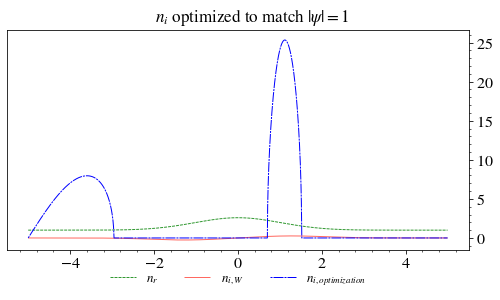

In [224]:
plt.close('all')
fig, ax = plt.subplots()
alphaVal = 1#0.6
linethick = 1

plt.plot(grid, 
         nr[:last_idx], 
         color=colourWheel[(0) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(0) % len(dashesStyles)],
         lw=linethick, 
         label = '$n_r$',
         alpha=alphaVal)

plt.plot(grid, 
         ni[:last_idx], 
         color=colourWheel[(1) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(1) % len(dashesStyles)],
         lw=linethick, 
         label = '$n_{i,W}$',
         alpha=alphaVal)

plt.plot(grid, 
         ni_calc[:last_idx], 
         color=colourWheel[(2) % len(colourWheel)],
         linestyle='-',
         dashes=dashesStyles[(2) % len(dashesStyles)],
         lw=linethick, 
         label = '$n_{i,optimization}$',
         alpha=alphaVal)

ax.set_xlabel('')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.major.formatter._useMathText = True
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_label_coords(0.53, 1.01)
ax.yaxis.tick_right()
nameOfPlot = '$n_i$ optimized to match $|\psi|=1$'
plt.ylabel(nameOfPlot, rotation=0)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
legend = ax.legend(frameon=False,
                   loc='upper center',
                   bbox_to_anchor=(0.5, -0.05),
                   ncol=4)

fig.savefig(path_plots + 'optimization_1.pdf', bbox_inches="tight", dpi=300)
plt.show()